# Spectral denoising as feature engineering

In this notebook we investigate the use of Fourier and Wavelet tranforms as a denosing pre-processing step prior to time series forecasting. This approach can be summarised as:
- step 1: Spectral tranforms of time series data, a transform from the time to frequency domain
- step 2: filter out high frequency noise components.
- step 3: inverses tranforms the frequency signal back to the time domain.
- step 4: forecasting the denoised signal. 

In [2]:
# import my bespoke modules
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2
from spectral_denoising import automatic_fourier_denoising, automatic_fourier_denoising_wf, automatic_wavelet_denoising, automatic_wavelet_denoising_wf

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

# general data wrangling and visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tabulate import tabulate



# 1. Fourier methods

In [ ]:
financial_assets = ['CrudeOil']#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_fourier'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:-split]) # data
    denoised_signal = automatic_fourier_denoising(signal,df, split,verbose=False)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=False,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10,
                                                                                    transformer=automatic_fourier_denoising_wf,
                                                                                    only_training=True,
                                                                                    verbose=False)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')



# 2. Wavelet methods

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


With your threshold applied the percetange is : 0.0


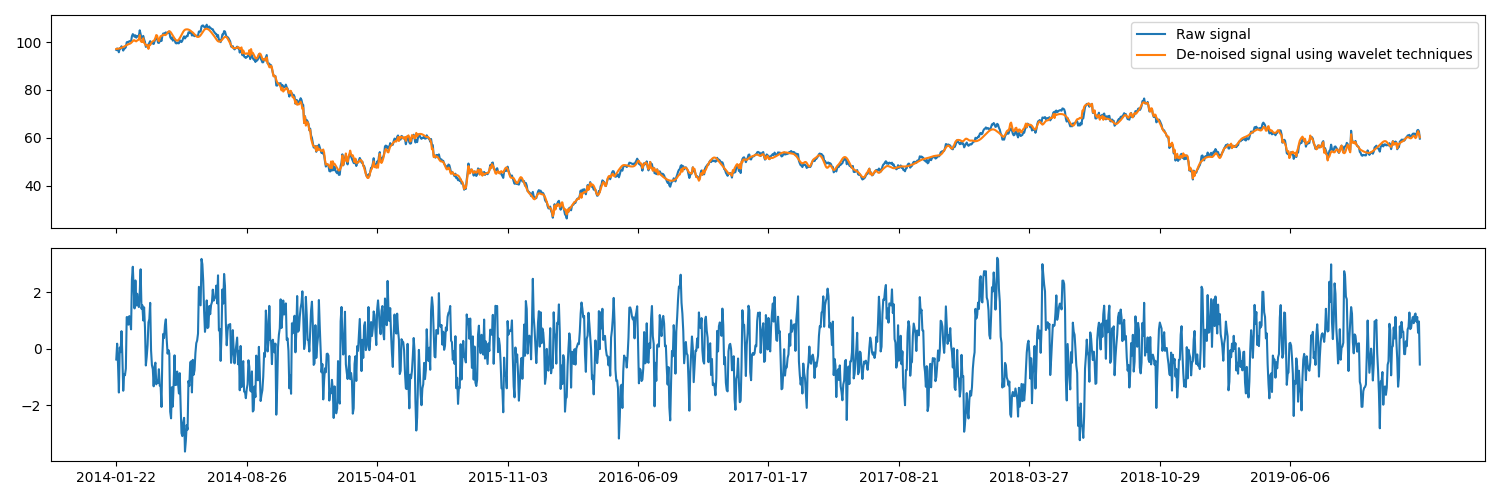

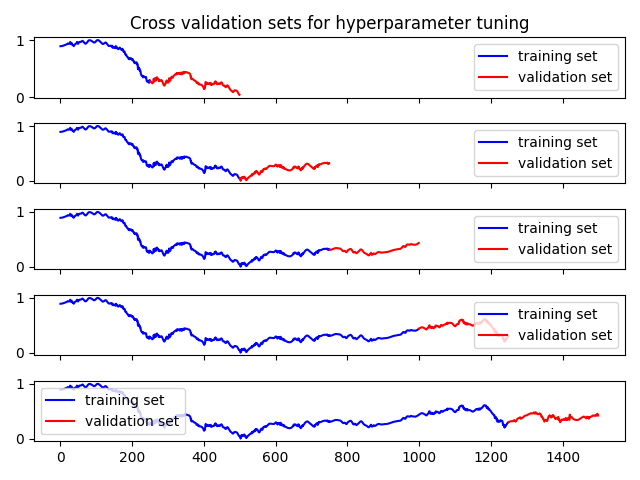

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.02297879 -0.11802662  0.1078132   0.02050422 -0.07370542 -0.03492337
  0.03594205 -0.09503532  0.19575191  0.93568087]
MAPE: 0.12553880195839098
RMSE:  0.023223756496956332
MAE:  0.014676677882597548

Naive model results:
MAPE: 0.1219143728560247
RMSE:  0.022721179557364406
MAE:  0.014160657804659388
Movement prediction accuracy: 45.77 %
Confusion matrix:
[[527 127]
 [681 155]]
Movement prediction accuracy: 43.89 %
Confusion matrix:
[[654   0]
 [836   0]]
Movement prediction accuracy: 43.89 %
Confusion matrix:
[[654   0]
 [836   0]]
Movement prediction accuracy: 45.64 %
Confusion matrix:
[[530 124]
 [686 150]]
Movement prediction accuracy: 43.89 %
Confusion matrix:
[[654   0]
 [836   0]]
+----+-------------------+-------------+-------------+------------+----------+--------------+
|    | model             |        RMSE |         MAE |       MAPE |       DA | parameters   |
|----+-------------------+---------

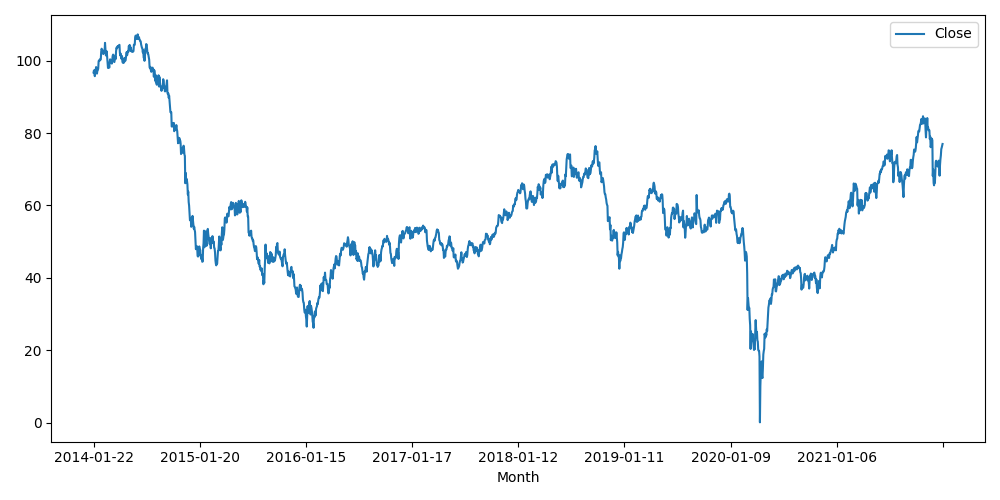

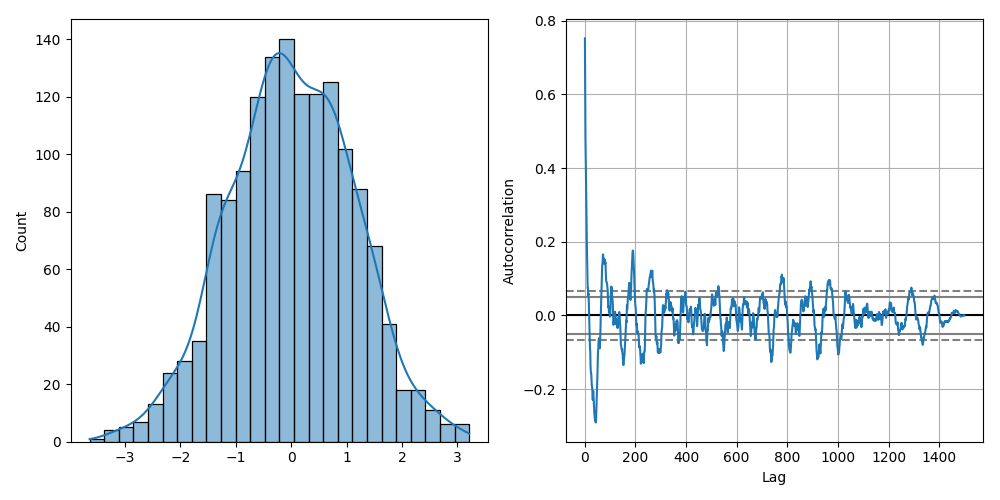

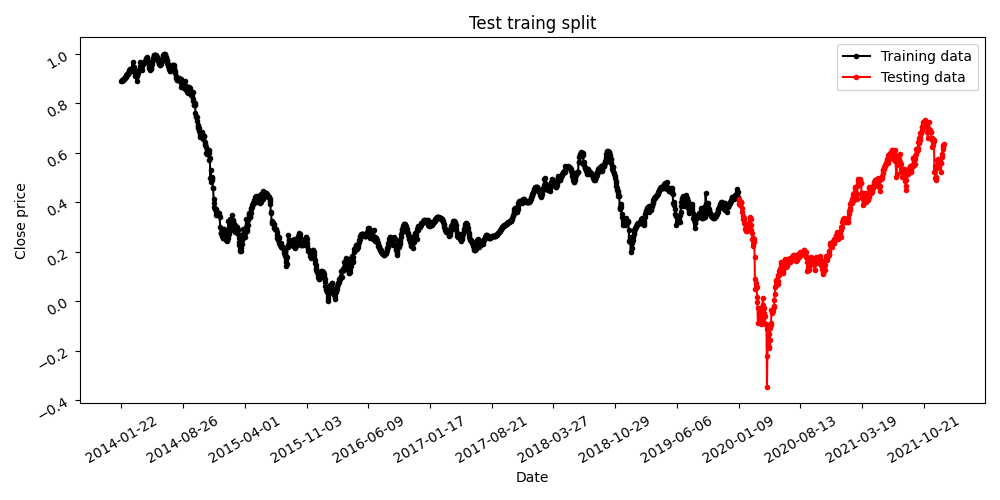

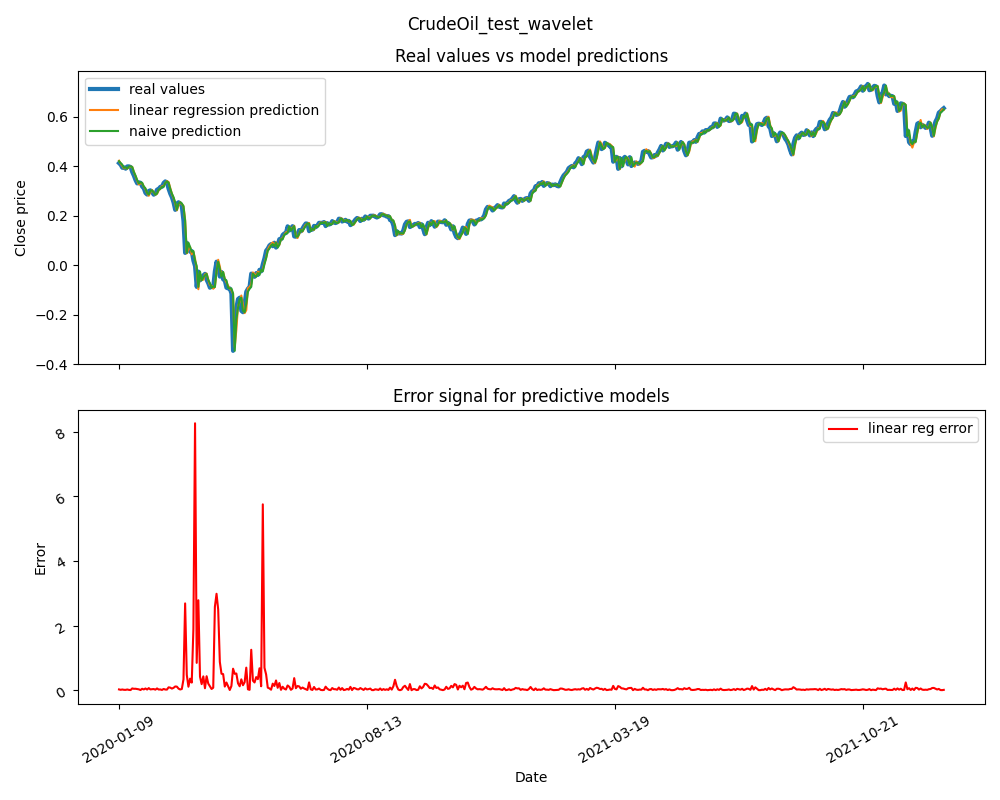

In [3]:
financial_asset = 'CrudeOil'#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_wavelet'
column_to_predict = 'Close' #'#Passengers' 

###################################################################################################
# import some data
###################################################################################################

df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
# df['Date'] = df['Month']
df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

# some forecasting parameters
window_length = 10
split = 500 # 44 for AirPlane

###################################################################################################
# feature engineering
###################################################################################################

# fft the testing data
signal = np.array(df[f'{column_to_predict}'][-2000:-split]) # data
denoised_signal = automatic_wavelet_denoising(signal,df, split,
                                                verbose=True,
                                                wavelet='db8',
                                                threshold_override=True, 
                                                threshold=0.4)

###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
# blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
# blah.neural_net_mlp(model_tunning=False,
#                     activation= 'relu', 
#                     hidden_layer_sizes= (100, 100, 100), 
#                     learning_rate= 'invscaling', 
#                     learning_rate_init= 0.001,
                    # solver='adam')
# blah.lstm(model_tunning=False,n_batch=64)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()


# 3. Moving averages

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


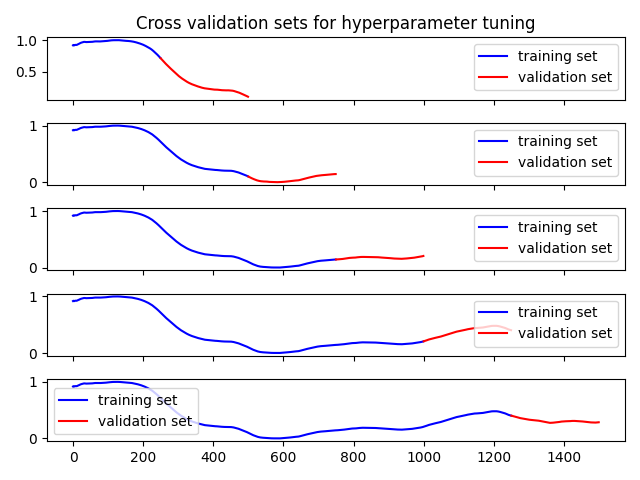

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.11992014 -0.17541176  0.1216478  -0.2352312   0.17259372  0.02553446
 -0.06312268  0.01541478 -0.91395026  1.9325571 ]
MAPE: 0.4792842299359376
RMSE:  0.04063260742617347
MAE:  0.024715742720487613

Naive model results:
MAPE: 0.318067206268526
RMSE:  0.028162619254845464
MAE:  0.0175798574478422
Movement prediction accuracy: 43.49 %
Confusion matrix:
[[522 108]
 [734 126]]
Movement prediction accuracy: 42.28 %
Confusion matrix:
[[630   0]
 [860   0]]
Movement prediction accuracy: 42.28 %
Confusion matrix:
[[630   0]
 [860   0]]
Movement prediction accuracy: 43.36 %
Confusion matrix:
[[508 122]
 [722 138]]
Movement prediction accuracy: 42.28 %
Confusion matrix:
[[630   0]
 [860   0]]
+----+-------------------+-------------+-------------+------------+----------+--------------+
|    | model             |        RMSE |         MAE |       MAPE |       DA | parameters   |
|----+-------------------+-------------+

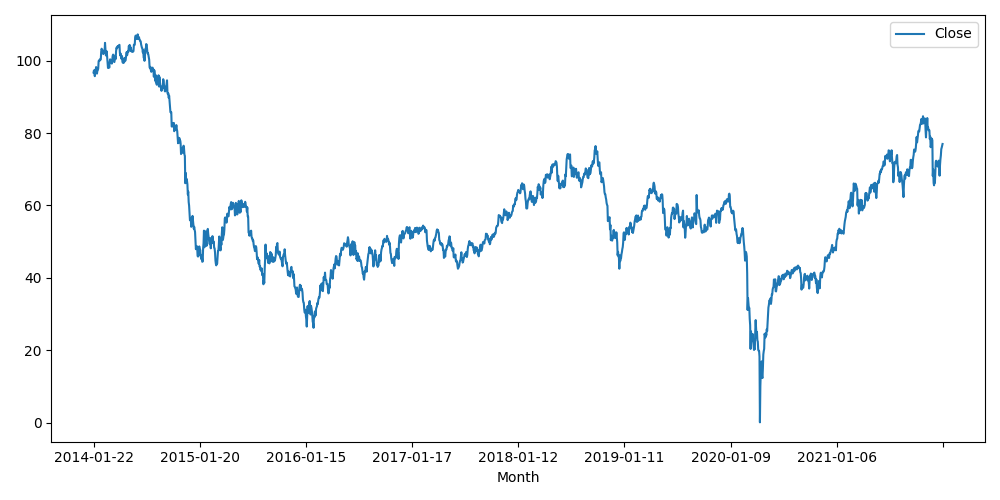

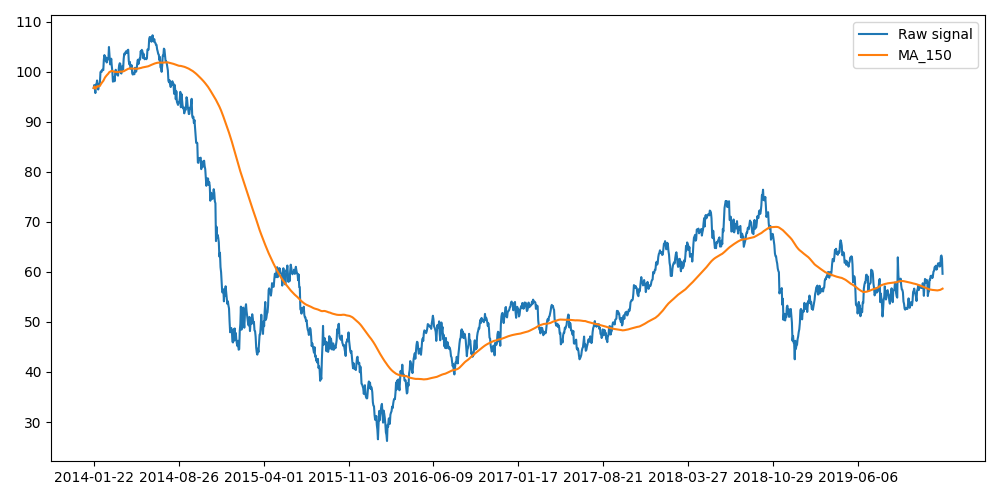

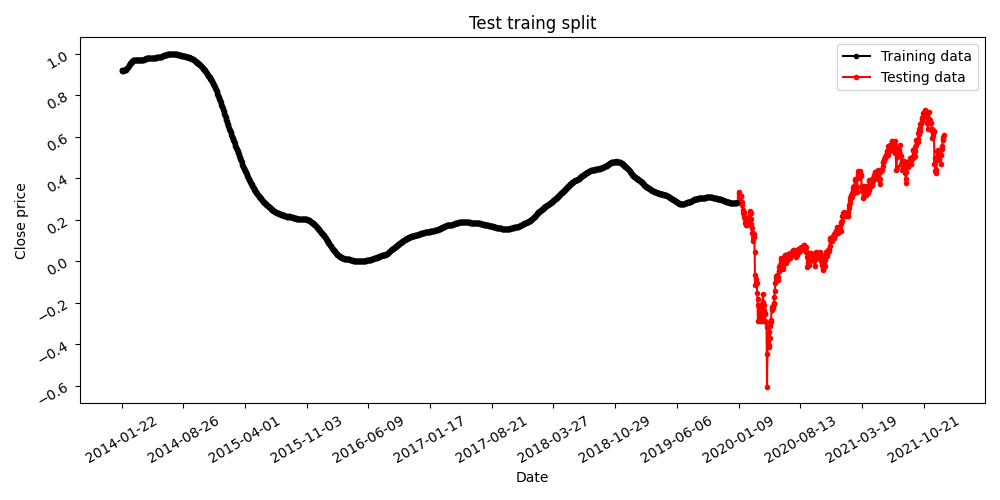

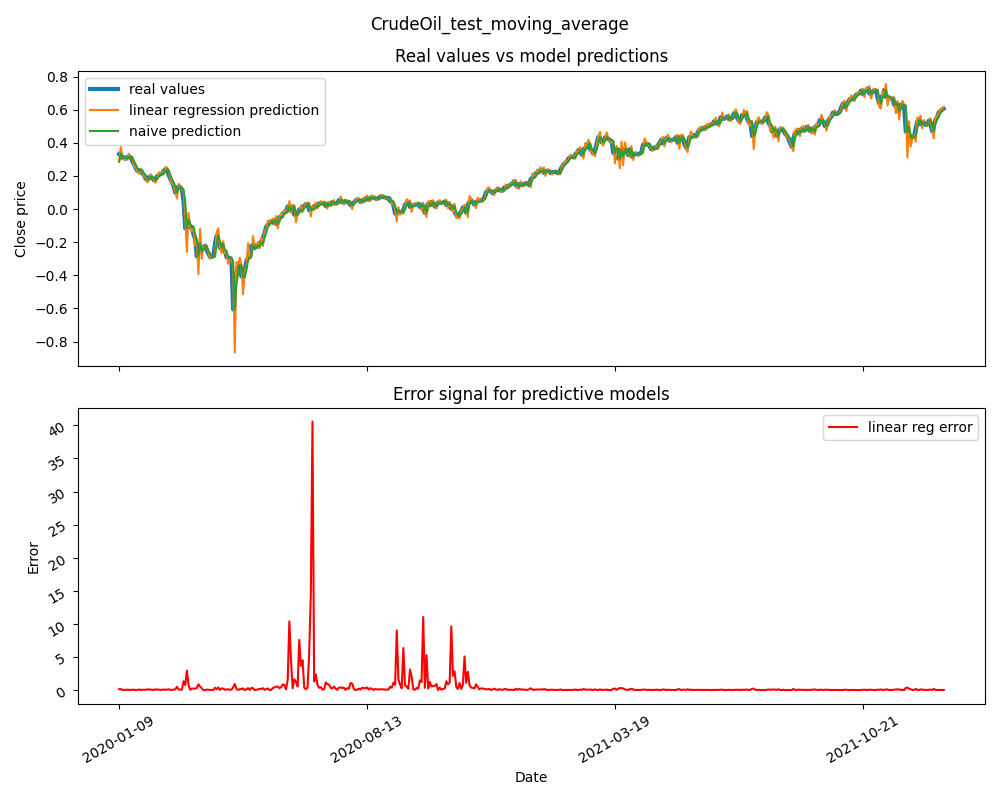

In [19]:
financial_asset = 'CrudeOil'#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_moving_average'
column_to_predict = 'Close' #'#Passengers' 

###################################################################################################
# import some data
###################################################################################################

df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
# df['Date'] = df['Month']
df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

# some forecasting parameters
window_length = 10
split = 500 # 44 for AirPlane

###################################################################################################
# feature engineering
###################################################################################################

# smoothen data
moving_average = 150
signal = df[f'{column_to_predict}'][-2000:-split] # data
denoised_signal = signal.rolling(moving_average,min_periods=1).mean().to_numpy()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
ax.plot(df['Date'][:-split], denoised_signal,label=f"MA_{moving_average}")
max = df.iloc[:-split,:].shape[0]
relevant_dates = df['Date'][:-split]
ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
plt.legend()
plt.tight_layout()
display(df)

###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
# blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
# blah.neural_net_mlp(model_tunning=False,
#                     activation= 'relu', 
#                     hidden_layer_sizes= (100, 100, 100), 
#                     learning_rate= 'invscaling', 
#                     learning_rate_init= 0.001,
                    # solver='adam')
# blah.lstm(model_tunning=False,n_batch=64)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()


# 4. Exponentially weighted moving average

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


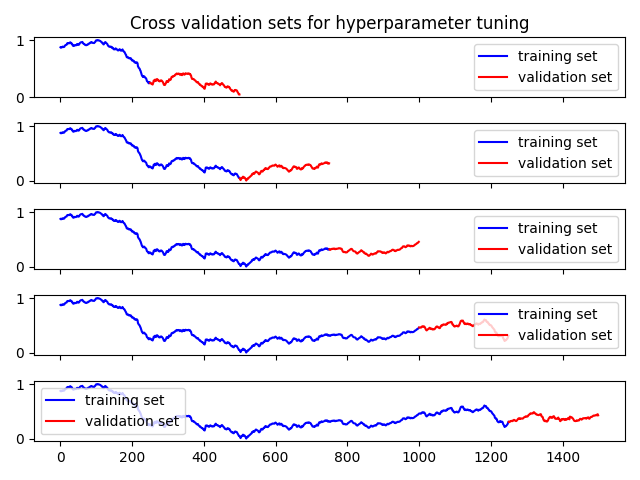

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.00228937 -0.01873972  0.01717884 -0.00279716 -0.03366426 -0.00388942
  0.07485845 -0.10758018 -0.33047558  1.40088413]
MAPE: 0.1227183209380718
RMSE:  0.02469922407543756
MAE:  0.015018679531063048

Naive model results:
MAPE: 0.12227587236951644
RMSE:  0.02239499850677148
MAE:  0.013972601963881316
Movement prediction accuracy: 47.58 %
Confusion matrix:
[[564 110]
 [671 145]]
Movement prediction accuracy: 45.23 %
Confusion matrix:
[[674   0]
 [816   0]]
Movement prediction accuracy: 45.23 %
Confusion matrix:
[[674   0]
 [816   0]]
Movement prediction accuracy: 46.98 %
Confusion matrix:
[[550 124]
 [666 150]]
Movement prediction accuracy: 45.23 %
Confusion matrix:
[[674   0]
 [816   0]]
+----+-------------------+-------------+-------------+------------+----------+--------------+
|    | model             |        RMSE |         MAE |       MAPE |       DA | parameters   |
|----+-------------------+-----------

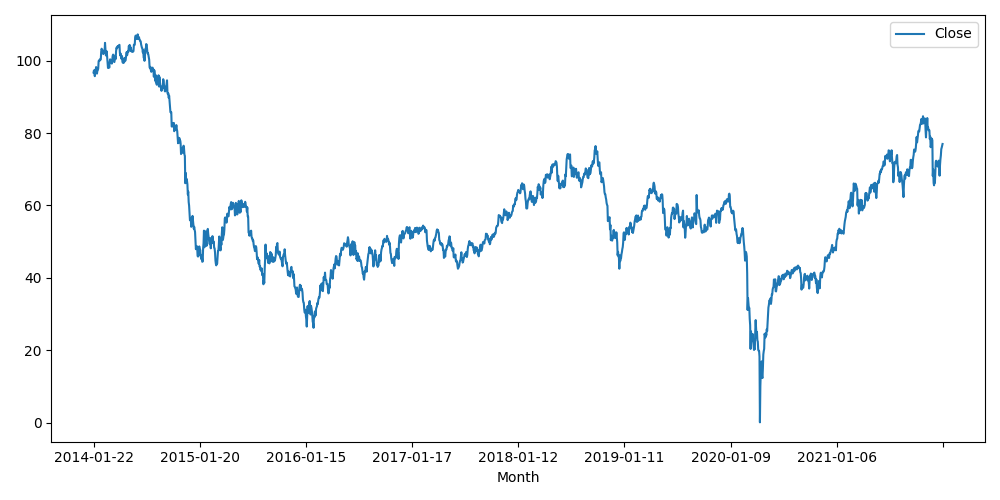

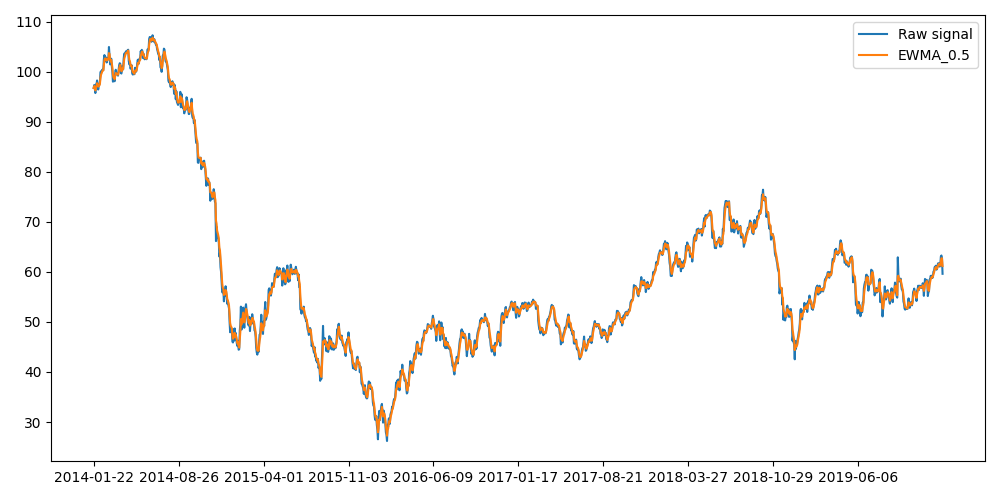

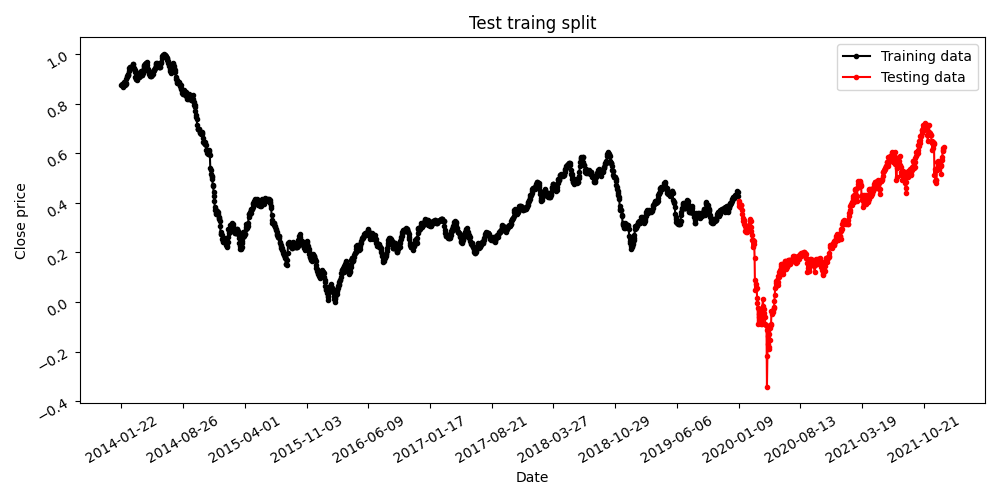

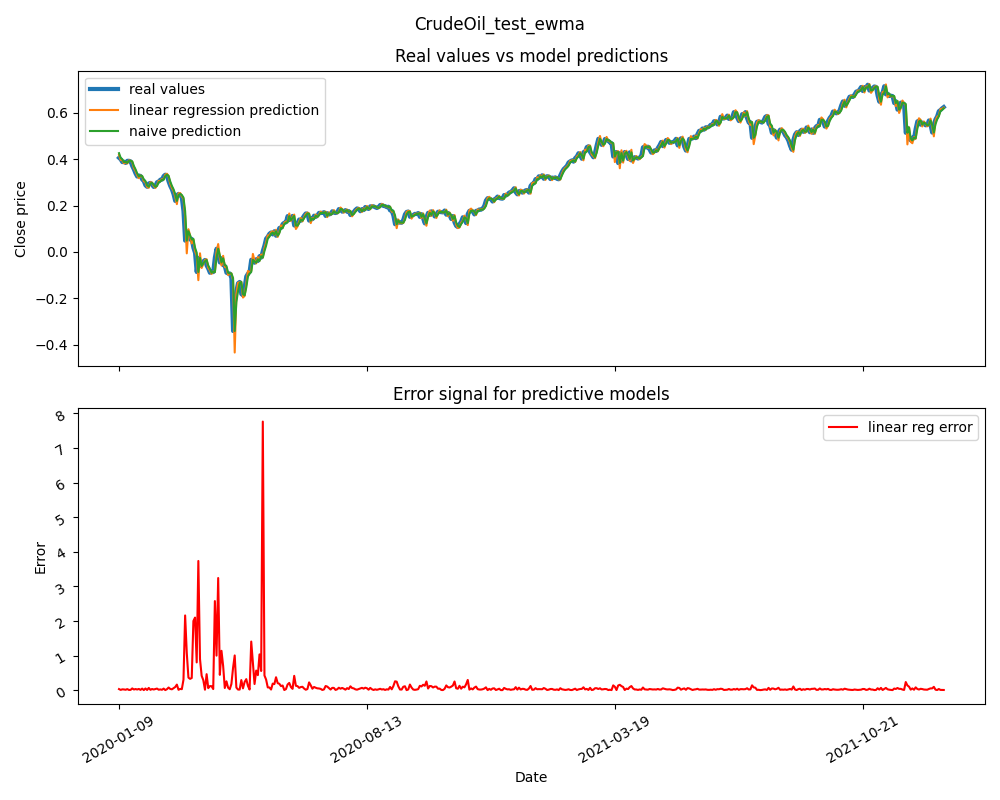

In [20]:
financial_asset = 'CrudeOil'#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_ewma'
column_to_predict = 'Close' #'#Passengers' 

###################################################################################################
# import some data
###################################################################################################

df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
# df['Date'] = df['Month']
df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

# some forecasting parameters
window_length = 10
split = 500 # 44 for AirPlane

###################################################################################################
# feature engineering
###################################################################################################

# smoothen data
alpha = 0.5 # smoothing parameter
signal = df[f'{column_to_predict}'][-2000:-split] # data
denoised_signal = signal.ewm(alpha=alpha).mean().to_numpy()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
ax.plot(df['Date'][:-split], denoised_signal,label=f"EWMA_{alpha}")
max = df.iloc[:-split,:].shape[0]
relevant_dates = df['Date'][:-split]
ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
plt.legend()
plt.tight_layout()
display(df)

###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
# blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
# blah.neural_net_mlp(model_tunning=False,
#                     activation= 'relu', 
#                     hidden_layer_sizes= (100, 100, 100), 
#                     learning_rate= 'invscaling', 
#                     learning_rate_init= 0.001,
                    # solver='adam')
# blah.lstm(model_tunning=False,n_batch=64)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()
